In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
import pandas as pd
from utils import target_loss 
import loader
from itertools import product
from sympy import Symbol, sympify
import json
from pysr import PySRRegressor
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
t_size = 25
size = 150
t_max = 5
n_formula = 0
t = np.linspace(0, t_max, t_size)
with open("equations.json", 'r') as json_file:
    formulas = json.load(json_file)
def data_gen(formulas, n_formula, size):
    formula_data = formulas["formulae"][n_formula]
    formula = sympify(formula_data["formula"])
    sym_vars = {i[0] : Symbol(i[0]) for i in formula_data["vars"]}
    vars = {}
    for var in formula_data["vars"]:
        if var[1] == "log":
            vars[sym_vars[var[0]]] = np.random.lognormal(var[-2], var[-1], size)
        elif var[1] == "normal":
            vars[sym_vars[var[0]]] = np.random.normal(var[-2], var[-1], size)
    combinations = product(*vars.values())
    combinations = [dict(zip(vars.keys(), values)) for values in combinations]
    results = []
    for combination in combinations:
        formula_no_time = float(formula.subs(combination).evalf())
        formula_output = list(formula_no_time * t)
        t_pred = np.random.uniform(0, t_max)
        pred = formula_no_time * t_pred
        result = {}
        result["vars"] = list(combination.values())
        result["timeserie"] = formula_output
        result["question"] = t_pred
        result["answer"] = pred
        results.append(result)
    return results
data = data_gen(formulas, n_formula, size)
data

[{'vars': [0.7936676538849777, 0.8187439428238286],
  'timeserie': [0.0,
   0.13537720504865092,
   0.27075441009730183,
   0.4061316151459527,
   0.5415088201946037,
   0.6768860252432546,
   0.8122632302919054,
   0.9476404353405564,
   1.0830176403892073,
   1.2183948454378581,
   1.3537720504865092,
   1.4891492555351602,
   1.6245264605838108,
   1.7599036656324618,
   1.8952808706811128,
   2.0306580757297636,
   2.1660352807784147,
   2.3014124858270657,
   2.4367896908757163,
   2.5721668959243673,
   2.7075441009730183,
   2.842921306021669,
   2.9782985110703204,
   3.113675716118971,
   3.2490529211676216],
  'question': 3.6834868985409956,
  'answer': 2.393568773557457},
 {'vars': [0.7936676538849777, 6.819177683612834],
  'timeserie': [0.0,
   1.1275334903287073,
   2.2550669806574146,
   3.3826004709861217,
   4.510133961314829,
   5.637667451643536,
   6.765200941972243,
   7.892734432300951,
   9.020267922629658,
   10.147801412958366,
   11.275334903287073,
   12.40286

In [3]:
dataset = loader.SciNet_loader(data=data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
# Setup scinet model with 3 latent neurons
scinet = SciNet(t_size,1,3,100).to(device)

# Training setup
N_EPOCHS = 20
SAVE_PATH = f"saved_models/scinet1-{t_size}epoch{N_EPOCHS}.dat"
optimizer = optim.Adam(scinet.parameters(), lr=0.001)
hist_error = []
hist_kl = []
hist_loss = []
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.005, total_iters=N_EPOCHS)
beta = 0.5
# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_kl = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, _, question, answer = minibatch['timeserie'] / 5, minibatch['vars'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5

        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1).to(device)
        # build the output
        outputs = answer.to(device)
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss_ = target_loss(pred, outputs)
        kl = beta * scinet.kl_loss
        loss = loss_ + kl
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).cpu().detach().numpy()
        epoch_error.append(error)
        epoch_kl.append(kl.data.cpu().detach().numpy())
        epoch_loss.append(loss_.data.cpu().detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    hist_kl.append(np.mean(epoch_kl))

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))
    
    print("Epoch %d -- loss %f, RMS error %f, KL %f" % (epoch+1, hist_loss[-1], hist_error[-1], hist_kl[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1: SGD lr 0.001000 -> 0.000950
Epoch 1 -- loss 516.234985, RMS error 0.741385, KL 11481525.000000
Epoch 2: SGD lr 0.000950 -> 0.000901
Epoch 2 -- loss 430.061462, RMS error 0.597304, KL 46.017139
Epoch 3: SGD lr 0.000901 -> 0.000851
Epoch 3 -- loss 404.980316, RMS error 0.607244, KL 54.584606
Epoch 4: SGD lr 0.000851 -> 0.000801
Epoch 4 -- loss 308.413788, RMS error 0.529395, KL 51.398197
Epoch 5: SGD lr 0.000801 -> 0.000751
Epoch 5 -- loss 389.804871, RMS error 0.581879, KL 12547.875977
Epoch 6: SGD lr 0.000751 -> 0.000702
Epoch 6 -- loss 322.227386, RMS error 0.574718, KL 4320.339844
Epoch 7: SGD lr 0.000702 -> 0.000652
Epoch 7 -- loss 427.753571, RMS error 0.625005, KL 25.361618
Epoch 8: SGD lr 0.000652 -> 0.000602
Epoch 8 -- loss 382.301880, RMS error 0.605048, KL 22.272356
Epoch 9: SGD lr 0.000602 -> 0.000552
Epoch 9 -- loss 349.777924, RMS error 0.573222, KL 21.578192
Epoch 10: SGD lr 0.000552 -> 0.000503
Epoch 10 -- loss 333.507538, RMS error 0.549469, KL 23.256710
Epoch 1

C:\Users\amine\AppData\Local\Temp\ipykernel_21536\3016749620.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


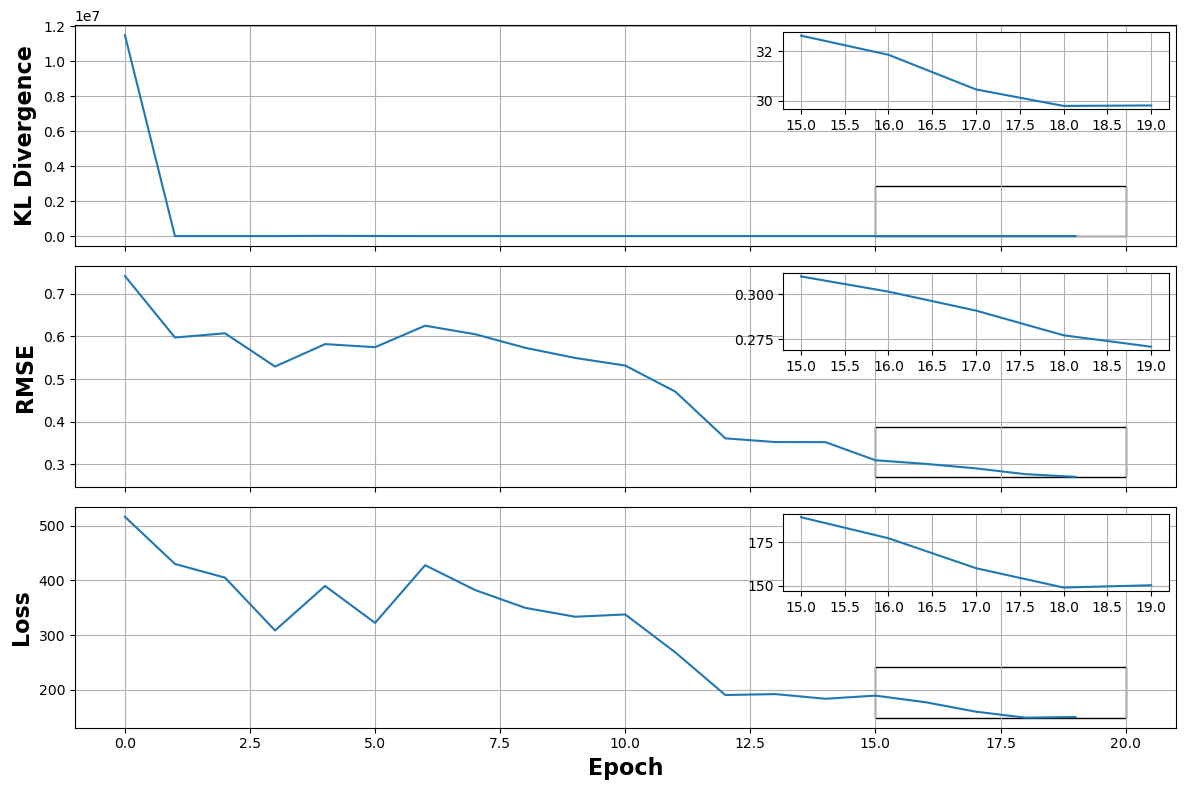

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Define the starting epoch for zooming in
start_epoch = 15  # Change this to your desired starting epoch
end_epoch = N_EPOCHS  # Change this to your desired ending epoch
epochs = list(range(N_EPOCHS))
# Plot the first subplot
axs[0].plot(epochs, hist_kl)
axs[0].set_ylabel("KL Divergence", fontsize=16, fontweight='bold')
axs[0].grid(True)

# Create an inset_axes for zooming in on the first subplotss
axins1 = inset_axes(axs[0], width="35%", height="35%", loc='upper right')
axins1.plot(epochs[start_epoch:end_epoch], hist_kl[start_epoch:end_epoch])
axins1.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect1 = Rectangle((start_epoch, min(hist_kl)), end_epoch - start_epoch, (max(hist_kl) - min(hist_kl)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[0].add_patch(rect1)

# Plot the second subplot
axs[1].plot(epochs, hist_error)
axs[1].set_ylabel("RMSE", fontsize=16, fontweight='bold')
axs[1].grid(True)

# Create an inset_axes for zooming in on the second subplot
axins2 = inset_axes(axs[1], width="35%", height="35%", loc='upper right')
axins2.plot(epochs[start_epoch:end_epoch], hist_error[start_epoch:end_epoch])
axins2.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect2 = Rectangle((start_epoch, min(hist_error)), end_epoch - start_epoch, (max(hist_error) - min(hist_error)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[1].add_patch(rect2)

# Plot the third subplot
axs[2].plot(epochs, hist_loss)
axs[2].set_xlabel("Epoch", fontsize=16, fontweight='bold')
axs[2].set_ylabel("Loss", fontsize=16, fontweight='bold')
axs[2].grid(True)

# Create an inset_axes for zooming in on the third subplot
axins3 = inset_axes(axs[2], width="35%", height="35%", loc='upper right')
axins3.plot(epochs[start_epoch:end_epoch], hist_loss[start_epoch:end_epoch])
axins3.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect3 = Rectangle((start_epoch, min(hist_loss)), end_epoch - start_epoch, (max(hist_loss) - min(hist_loss)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[2].add_patch(rect3)

# Adjust layout
plt.tight_layout()

# Show the plot (optional)
plt.show()


### Symbolic Formulation

In [5]:
model_path = 'saved_models/scinet1-25epoch20.dat'
model = SciNet(t_size,1,3,100).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
epoch_error = []
for i_batch, minibatch in enumerate(dataloader):
        time_series, _, question, answer = minibatch['timeserie'] / 5, minibatch['vars'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5

        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1).to(device)
        # build the output
        outputs = answer.to(device)
        optimizer.zero_grad()
        pred = model.forward(inputs)
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).cpu().detach().numpy()
        epoch_error.append(error)
sum(epoch_error) / len(epoch_error)


0.269238921503226

In [7]:
timeseries = np.array([i["timeserie"] for i in data])
timeseries = torch.tensor(timeseries, dtype=torch.float32).to(device)
scinet_latent = model.encoder(timeseries / 5).cpu().detach().numpy()
scinet_latent

array([[-0.7188597 ,  0.49766037, -0.8555878 ],
       [ 0.24547185,  0.3460665 ,  0.7588141 ],
       [-0.33478594,  0.17648873, -0.8916291 ],
       ...,
       [-0.2548953 ,  0.1722795 , -0.6735879 ],
       [ 0.28537172, -0.509884  , -0.8214884 ],
       [-0.08286646, -0.4831369 , -0.317681  ]], dtype=float32)

In [8]:
question = np.array([[i["question"]] for i in data])
answer = np.array([i["answer"] for i in data])
x = np.concatenate([scinet_latent, question], axis=1)
y = answer

In [9]:
model = PySRRegressor(
    niterations=70,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [10]:
model.fit(x,y)

c:\Users\amine\miniconda3\envs\net\Lib\site-packages\pysr\sr.py:1281: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\amine\miniconda3\envs\net\Lib\site-packages\pysr\sr.py:1850: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  warnings.warn(
c:\Users\amine\miniconda3\envs\net\Lib\site-packages\pysr\julia_helpers.py:171: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before*

Compiling Julia backend...
